In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 
import torch 
from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from PIL import Image
import torchvision
from torchvision.models.resnet import resnet18, resnet50
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets 

device = torch.device('cpu')
# device = torch.device('cpu')

In [2]:
torch.cuda.empty_cache()

In [3]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [4]:
import art
from art import attacks 
from art.attacks.evasion import DeepFool, CarliniL0Method, BasicIterativeMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from torch.utils.data import ConcatDataset

In [5]:
# defining hyperparameters  
epochs = 5  #the nn will train 29 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [6]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [7]:
valid_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [8]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    global base_dataset 
    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset, train_dataset
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    # valid_loader = torch.utils.data.DataLoader(
    #     val_dataset, batch_size=batch_size,
    #     num_workers=num_workers, 
    #     #sampler = valid_sampler
    # )

    return train_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


In [39]:
# Weet je nog waarom we de layers hieronder hebben aangepast?
model = resnet18(pretrained = False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 43)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Adversarial training

In [29]:
plot_output = []
iterations = 10
adv_examples = []
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose=False)
    examples = []
    for j, (image, true_label) in enumerate(train_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adv_input = (torch.from_numpy(X_adv)).to(torch.float32)
        adversarial_prediction = torch.argmax(adv_input).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            examples.append((adversarial_prediction, X_adv))
        
        if j > 1:
            break
    adv_examples.append(examples)
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print(adv_examples)



ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [ ]:
class AdvExamplesDataset(object):
    def __init__(self, adv_examples):
        self.adv_examples = adv_examples
    def __len__(self):
        return len(self.adv_examples)
    def __getitem__(self, idx):
        return self.adv_examples[idx]

adv_examples_dataset = AdvExamplesDataset(adv_examples)
concatenated_dataset = torch.utils.data.ConcatDataset([base_dataset, adv_examples_dataset])

In [ ]:
concatenated_dataloader = torch.utils.data.DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for a, b in concatenated_dataloader:
    print(b)

In [ ]:
# trial 2
class AdversarialDataset(adv_examples):
    def __init__(self, adv_examples):
        self.base_dataset = adv_examples
        self.adv_examples = adv_examples

    def __getitem__(self, index):
        X, y = self.base_dataset[index]
        X_adv, y_adv = self.adv_examples[index]
        return (X_adv, y_adv)

    def __len__(self):
        return len(self.base_dataset)

# Example usage
base_dataset = torchvision.datasets.GTSRB(
root='./data', split = 'train', transform=transforms, download=True) # replace with your own dataset
# attack =  BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose=False)  # replace with your own attack function
adversarial_dataset = AdversarialDataset(base_dataset, adv_examples)
adversarial_loader = DataLoader(adversarial_dataset, batch_size=batch_size, shuffle=True)


In [9]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [10]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [11]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [12]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [13]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [17]:
model = resnet18(pretrained = False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 43)
model = model.to(device)

In [15]:
device

device(type='cpu')

In [74]:
# model = resnet50(pretrained=False)
# model.fc = torch.nn.Linear(2048,43)
# model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

# model = model.to(device)

In [18]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [75]:
model = model.to(device)

19:36:02 --- Epoch: 0	Train loss: 1.6073	Valid loss: 1.4747	Train accuracy: 86.08	Valid accuracy: 57.17
19:38:29 --- Epoch: 1	Train loss: 0.3426	Valid loss: 1.2462	Train accuracy: 96.59	Valid accuracy: 65.46
19:40:57 --- Epoch: 2	Train loss: 0.0991	Valid loss: 1.1767	Train accuracy: 98.57	Valid accuracy: 68.35
19:43:25 --- Epoch: 3	Train loss: 0.0500	Valid loss: 1.2238	Train accuracy: 97.83	Valid accuracy: 68.73
19:46:19 --- Epoch: 4	Train loss: 0.0417	Valid loss: 1.3063	Train accuracy: 98.18	Valid accuracy: 67.47


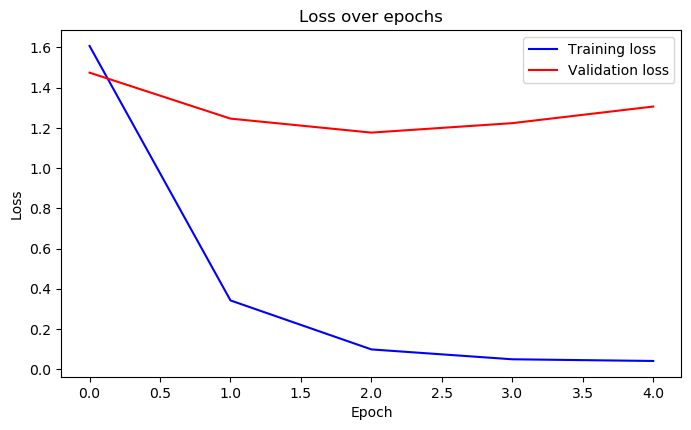

In [68]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)  #50

In [76]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

19:53:47 --- Epoch: 0	Train loss: 3.9638	Valid loss: 3.9474	Train accuracy: 1.04	Valid accuracy: 0.78
19:59:43 --- Epoch: 1	Train loss: 3.9638	Valid loss: 3.9474	Train accuracy: 1.04	Valid accuracy: 0.78


KeyboardInterrupt: 

In [73]:
torch.save(model.state_dict(), "resnet18_trained.pt")

In [19]:
model.load_state_dict(torch.load("resnet18.pt"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)

# CW attack 

In [21]:
plot_output_base = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    # attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(valid_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_base.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_base)

Average Success Rate: 0.45% [(0, 0.7272727272727273), (1, 0.6818181818181819), (2, 0.6818181818181819), (3, 0.6818181818181819), (4, 0.6363636363636364), (5, 0.6363636363636364), (6, 0.6363636363636364), (7, 0.5909090909090908), (8, 0.5909090909090908), (9, 0.5454545454545454)]


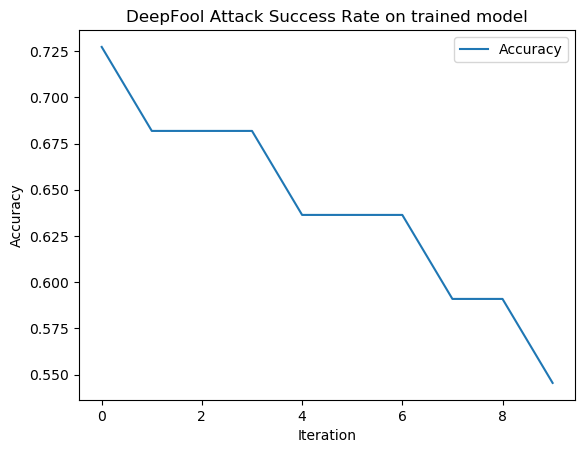

In [22]:
x = [p[0] for p in plot_output_base]
y = [p[1] for p in plot_output_base]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('DeepFool Attack Success Rate on trained model')
plt.legend(loc='upper right')
plt.show()  #0.71

In [71]:
plot_output_base = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(valid_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adv_input = (torch.from_numpy(X_adv)).to(torch.float32)
        adversarial_prediction = torch.argmax(adv_input).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_base.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_base)

Average Success Rate: 0.77% [(0, 0.2272727272727273), (1, 0.2272727272727273), (2, 0.2272727272727273), (3, 0.2272727272727273), (4, 0.2272727272727273), (5, 0.2272727272727273), (6, 0.2272727272727273), (7, 0.2272727272727273), (8, 0.2272727272727273), (9, 0.2272727272727273)]


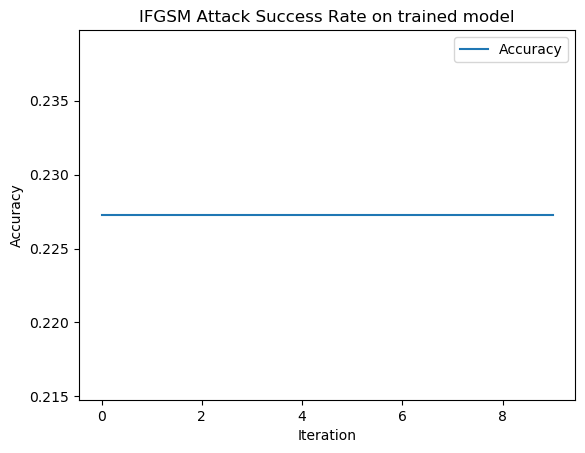

In [72]:
x = [p[0] for p in plot_output_base]
y = [p[1] for p in plot_output_base]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('IFGSM Attack Success Rate on trained model')
plt.legend(loc='upper right')
plt.show()  #0.71